## Deconvolution Simulation Experiments 3: jackknife edition! 
#### Christa Caggiano 
#### September 7th 2018 


Simulations for cfDNA tissue of origin deconvolution. Given an observed matrix of methylation counts for each CpG from whole genome bisulfite sequencing, and a reference matrix of the cannonical proportion methylation for each CpG in each tissue, estimates how much of the cfDNA comes from each tissue in the reference. 

In these simulations, I will try to compute jackknife error statistics from simulated and real data in order to test the reproducibility of my optimization experiments. 

In [1]:
#### python packages ####
import pandas as pd
import numpy as np 
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline

######### loading my python modules for deconvolution ########### 
#### https://github.com/christacaggiano/cfDNA-deconvolution #####

# this code needed to load my modules in a jupyter notebook 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from simulation.simulation_utils import *  # various utils for making simulated data 
from simulation.simulate import generate_simulated_optimization  # takes parameters and makes simulated matrices for optimization 
from optimization.quadratic_programming_optimization import perform_optimization as qp  # performs quadratic programming optimization
from optimization.naive_optimization import perform_optimization as naive  # 'naive' optimization that divides by sum 

### Experiment 3a: 

**_Goal_**: start simply. Convince myself that if I simulate data with little or no variance, my jackknife will not have crazy error, and can accurately recapitulate the true mean. 

**Outline**: (from discussion with D. Seigel) 
* Simulate observed methylation data with known distribution (try Poisson, normal, negative bionomial) 
* Plot the data 
* Perform jackknife and plot the resampled data. Perform simulation a large number of times, 1,000 
* Calculate and plot jackknife statistics. Compare with known stdev from simulation 

#### Parameters 

Unlike in experiments 1 & 2, don't use real data yet. 

In [48]:
individuals = 1  # number of individuals to optimize around 
sites = 100  # number of CpG sites 
tissues = 5 # number of tissues in reference 
proportions = np.array((1, 0, 0, 0, 0))
method = qp # optimization method, in this case, quadratic programming 
center = 0.5 # "center" of methylation array values 
stdev = 0.1  # small SD so the methylation values are reasonable 
read_depth = 100 

#### Experiment 3a part 1: normal distribution 

start with a normal distribution that rounds everything below zero to zero, and everything above one to one. 

In [19]:
normal = np.random.normal(center, stdev, (tissues, sites))

In [45]:
# check that the mean and stdev are close to expectation 
np.mean(normal)
np.std(normal)

0.091390351794557262

#### Plot Distributions 
visually inspect the distribution of methylation values in 'normal' reference

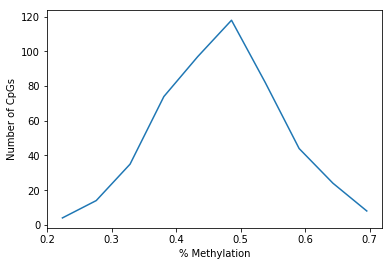

In [62]:
y, x = np.histogram(normal)
fig, ax = plt.subplots()
ax.plot(x[:-1], y)
ax.set_xlabel("% Methylation")
ax.set_ylabel("Number of CpGs")

#### Generate observations
Using the normally distributed reference data, generate observations that are at first, 100% tissue 1. 

In [63]:
reshaped_proportions = np.reshape(proportions, (1, proportions.shape[0]))
observed = np.matmul(reshaped_proportions, normal)

In [64]:
# check that the observed data is also normal, with our defined mean and standard deviation 
np.mean(observed)
np.std(observed)

0.088744021798945694

#### Plot observations 
Check that the shape of the observations is normal given the multiplication to obtain them 

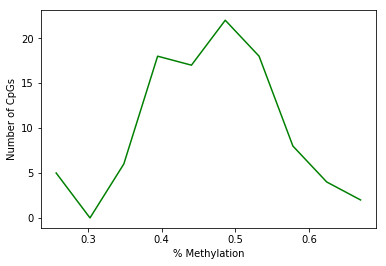

In [65]:
y, x = np.histogram(observed)
fig, ax = plt.subplots()
ax.plot(x[:-1], y, color="g")
ax.set_xlabel("% Methylation")
ax.set_ylabel("Number of CpGs")

#### Generate counts
generate read counts at 100x depth, run optimization using quadratic programming to obtain estimate of tissue proportions using all read counts 

In [66]:
depth = generate_depth(sites, individuals, read_depth)
methylated = generate_counts(depth, observed, sites, individuals)  # generate counts using poisson distribution 
unmethylated = depth - methylated

#### Run Optimization

In [47]:
def generate_optimization(reference, methylated, unmethylated, method):
    """
    using predefined reference and observed proportions, runs an optimization algorithm of choice 
    :param reference (np.array) array of methylation observations 
    :param methylated (np.array)array of methylated counts 
    :param unmethylated (np.array) array of unmethylated counts 
    :param method (string) optimization method
    
    :return estimated proportions  
    
    """
    
    # create initial proportions estimates 
    proportions_est = np.zeros((1, reference.shape[0])) + 0.5  
    proportions_est = proportions_est / (np.sum(proportions_est))

    return method(proportions_est, reference, methylated, unmethylated)

In [67]:
# run optimization using above sites
all_sites = generate_optimization(normal, methylated, unmethylated, qp)

#### Perform jack-knife to estimate errors 
Perform jack-knife leave one out resampling to get an estimate of the error 

In [68]:
# perform jack-knife, leaving the same cpg out of the reference and observed matrices. Performed in order

jackknife_estimate = []

for cpg in range(normal.shape[1]):
    estimate = generate_optimization(np.delete(normal, cpg, 1), np.delete(methylated, cpg, 1), np.delete(unmethylated, cpg, 1), qp)
    jackknife_estimate.append(estimate)

In [57]:
# calculate the jack knife error using formula from http://www.helsinki.fi/~rummukai/lectures/montecarlo_oulu/lectures/mc_notes5.pdf

error = np.zeros(all_sites.shape[0])

for row in jackknife_estimate:
    error += np.square(row - all_sites)
overall_error = np.sqrt(error*((error.shape[0]-1)/error.shape[0]))
overall_error

array([  3.03582761e-02,   2.12485755e-16,   3.03582761e-02,
         1.24309214e-16,   5.59036235e-17])

#### Plot Estimate with jack knife error estimate 

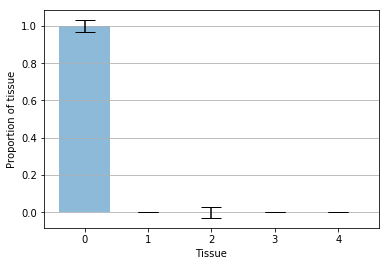

In [69]:
x_pos = np.arange(len(overall_error))
fig, ax = plt.subplots()
ax.bar(x_pos, all_sites, yerr=overall_error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel("Proportion of tissue")
ax.set_xlabel("Tissue")
ax.set_xticks(x_pos)
ax.yaxis.grid(True)

In [79]:
normal = np.random.normal(center, stdev, (tissues, sites))
reshaped_proportions = np.reshape(proportions, (1, proportions.shape[0]))
observed = np.matmul(reshaped_proportions, normal)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999383005702
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


#### Experiment 3: Real Data

using the same data as in experiment 1 and 2, get an idea of the distribution of the 'real' data and see if it can be recapitulated in the jackknife 

In [24]:
# Tissues included in this data set, in the order that they appear
# neurosphere	liver	brain_germinal	brain_hipp	atrium 	ventricle	thymus 	spleen	cd34	4star

roadmap_dmrs = pd.read_csv("../data/deconvolution_exp1_10_tissues.csv")  # load in the roadmap dmrs
roadmap_dmrs_drop_na = roadmap_dmrs.dropna()  # for now, just drop any missing data. Later experiments will test ways of dealing with Na's more intelligently 

In [25]:
roadmap_dmrs = roadmap_dmrs_drop_na.iloc[:, 3:] # drop chrom information because it's not important for computation 
roadmap_dmrs["var"] = roadmap_dmrs.var(axis=1, skipna=True)  # calculate row variance 
roadmap_dmrs_top10000 = roadmap_dmrs.sort_values(by="var", ascending=False).iloc[:10000,:-1]  # take the top 10,000 most variable sites 

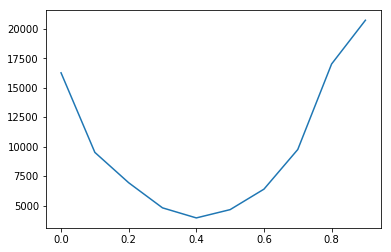

In [26]:
y, x = np.histogram(roadmap_dmrs_top10000)
fig, ax = plt.subplots()
ax.plot(x[:-1], y) 

In [ ]:
 # jackknife_estimate = []
        # for cpg in range(reference.shape[1]):
        #     estimate = generate_optimization(np.delete(reference, cpg, 1), np.delete(methylated, cpg, 1), np.delete(unmethylated, cpg, 1), qp)
        #     jackknife_estimate.append(estimate)
        #